<a href="https://colab.research.google.com/github/dcolinmorgan/AXA_AE_app/blob/main/DM_AXA_AE_jraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup: Install and Import libraries
[modified from tutorial HERE](https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb) |  
[merge with this](https://keras.io/examples/timeseries/) |   [also this](https://github.com/deepmind/graph_nets)

In [ ]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

In [44]:
# Imports
%matplotlib inline
import functools,glob,jax,jraph,optax,pickle,flax,os,collections,gzip
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.tree_util as tree
import haiku as hk
import absl as app
import numpy as np
import networkx as nx
import pandas as pd
from geopy.geocoders import Nominatim
import geopy.distance

from typing import Any, Callable, Dict, List, Optional, Tuple

StatefulField = collections.namedtuple("StatefulField", ["embedding", "state"])


Let's load the dataset:

In [ ]:
# !wget https://github.com/dcolinmorgan/AXA_AE_app/raw/main/axa_p.zip
# !7z x /content/axa_p.zip
# !git clone https://github.com/dcolinmorgan/aqi-stations-scraper.git

df2=pd.read_parquet('/content/AE_AXA_dat_full.parquet')


# list_a = ['pneumonia', 'COPD','asthma','resp','lung','pulm']#,'~Cancer']
# list_b = ['Cancer']
df2.columns=['pat_id','cd9_loc','sess','sex','age','cd9_code','mini_loc','loc1','date','tmp','diag1','diag2','tmp']

# df2=df[df['diag1'].isin(list_a)]
# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

# df.diag1, df.diag2 = np.where(df.diag1.str.contains('None'), [df.diag2, df.diag1], [df.diag1, df.diag2])
# del df['sess'], df['tmp'], df['diag2']
# df=df[~df['diag1'].isna()]

# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

df2.replace({'RH':'Ruttonjee Hospital'},inplace=True)
df2.replace({'PYN':'Pamela Youde Nethersole Eastern Hospital'},inplace=True)
df2.replace({'QEH':'Queen Elizabeth Hospital'},inplace=True)
df2.replace({'CMC':'Caritas Medical Centre'},inplace=True)
df2.replace({'KWH':'Kwong Wah Hospital'},inplace=True)
df2.replace({'TMH':'Tuen Mun Hospital'},inplace=True)
df2.replace({'PWH':'Prince of Wales Hospital'},inplace=True)
df2.replace({'NDH':'North District Hospital'},inplace=True)
df2.replace({'YCH':'Yan Chai Hospital'},inplace=True)
df2.replace({'UCH':'United Christian Hospital'},inplace=True)
df2.replace({'QMH':'Queen Mary Hospital'},inplace=True)
df2.replace({'PWH':'Princess Margaret Hospital'},inplace=True)
df2.replace({'POH':'Pok Oi Hospital'},inplace=True)
df2.replace({'TKO':'Tseung Kwan O Hospital'},inplace=True)
df2.replace({'AHN':'Alice Ho Miu Ling Nethersole Hospital'},inplace=True)
df2.replace({'SJH':'St. John Hospital'},inplace=True)
df2.replace({'NLT':'North Lantau Hospital'},inplace=True)
df2.replace({'TSH':'Tang Shiu Kin Hospital'},inplace=True)
df2.replace({'PMH':'Princess Margaret Hospital'},inplace=True)


#organize
cc=pd.DataFrame()#(columns=['date','pm25','pm10','o3','no2','so2','co','loc'])
files=glob.glob('/content/aqi-stations-scraper/data/japan-aqi/*')
for file in files:
    data=pd.read_csv(file,sep=' |,')
    data['loc1']=os.path.basename(file).split(',')[0]
    cc=cc.append(data)

data2=cc[['date','pm25','pm10','o3','no2','so2','co','loc1']]
data2['loc1']=data2['loc1'].str.upper().replace({'-':' '},regex=True)
data2['date']=pd.to_datetime(data2['date'])

geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(df2['cd9_loc'])):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]


data2.replace('CENTRALNAYA STR','central',inplace=True)
data2.replace('SOUTHERN','southern island',inplace=True)
data2.replace('SOUTHERN PART OF CHENGYANG DISTRICT','chengyang district',inplace=True)

data_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(data2['loc1'])):
    try:
        a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    except AttributeError:
        print('no location data for: '+str(i))
    data_loc[ii]=[a,b,i]
data_loc=data_loc.transpose()
data_loc.columns=['lat','long','name']
data_loc=data_loc[3:]

data_loc=data_loc[~data_loc.duplicated(['lat','long'],keep='first')]
data_loc.reset_index(inplace=True)

data_loc=df_loc.append(data_loc)[['lat','long','name']]
2
data_loc.reset_index(inplace=True)


# geopy DOES use latlon configuration
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))
square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)

# replacing distance.vicenty with distance.distance
def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )

distances = square.apply(get_distance, axis=1).T

data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
D_D=pd.DataFrame((distances<5)*1)
D_D.index=data_loc['src']
D_D.columns=data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
E_E.reset_index(inplace=True)#
distance_mat=E_E[E_E[0]>0]

distance=distances
distance.index=data_loc['src']
distance.columns=data_loc['dst']
distance=pd.DataFrame(distance.stack())
distance.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)

distances.to_numpy()

### paired-coding demo

In [4]:
from sklearn.metrics import mean_absolute_error,r2_score,accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

import seaborn as sns,numpy as np, pandas as pd

In [ ]:
!wget https://github.com/dcolinmorgan/AXA_AE_app/raw/main/coord_fulldiag_UVI_min.npy.gz
!7z x /content/coord_fulldiag_UVI_min.npy.gz

data5=np.load('/content/coord_fulldiag_UVI_min.npy',allow_pickle=True)
data5=pd.DataFrame(data5,columns=['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'lat',
       'long', 'name', 'year', 'week', 'diag1', 'UVI'])

data5['weekA']=data5['week']+(52*(data5['year']-np.nanmin(data5['year'])))

In [6]:
MATCHED_DATA=data5.groupby(['pm25','pm10','o3','no2','so2','co','lat','long','UVI','weekA']).agg('count')
MATCHED_DATA.reset_index(inplace=True)
y = MATCHED_DATA.diag1
MATCHED_DATA.drop(['diag1'], axis=1, inplace=True)
X = MATCHED_DATA[['pm25','pm10','o3','no2','so2','co','UVI','weekA']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [7]:
SGD= SGDClassifier()
SGD.fit(X_train,y_train)

KNN= KNeighborsClassifier()
KNN.fit(X_train,y_train)

DTC= DecisionTreeClassifier()
DTC.fit(X_train,y_train)

RFC= RandomForestClassifier()
RFC.fit(X_train,y_train)

LGBM= LGBMClassifier()
LGBM.fit(X_train,y_train)
  
XGB= XGBClassifier()
XGB.fit(X_train,y_train)


XGBClassifier(objective='multi:softprob')

In [8]:
results=pd.DataFrame(index=['ACC','MAE','R2'])

predA=SGD.predict(X_test)
results['SGC']=[accuracy_score(y_test,predA),mean_absolute_error(y_test,predA),r2_score(y_test,predA)]
predB=KNN.predict(X_test)
results['KNN']=[accuracy_score(y_test,predB),mean_absolute_error(y_test,predB),r2_score(y_test,predB)]
predC=DTC.predict(X_test)
results['DTC']=[accuracy_score(y_test,predC),mean_absolute_error(y_test,predC),r2_score(y_test,predC)]
predD=RFC.predict(X_test)
results['RFC']=[accuracy_score(y_test,predD),mean_absolute_error(y_test,predD),r2_score(y_test,predD)]
predE=LGBM.predict(X_test)
results['LGBM']=[accuracy_score(y_test,predE),mean_absolute_error(y_test,predE),r2_score(y_test,predE)]
predF=XGB.predict(X_test)
results['XGB']=[accuracy_score(y_test,predF),mean_absolute_error(y_test,predF),r2_score(y_test,predF)]


results
# print("GSD ACC: ", accuracy_score(y_test,predA),
#       ", SGD MAE: ",mean_absolute_error(y_test,predA),
#       ", SGD R2: ",r2_score(y_test,predA))

# predB=KNN.predict(X_test)
# print("KNN ACC: ", accuracy_score(y_test,predB),
#       ", KNN MAE: ",mean_absolute_error(y_test,predB),
#       ", KNN R2: ", r2_score(y_test,predB))

# predC=DTC.predict(X_test)
# print("DTC ACC: ", accuracy_score(y_test,predC),
#       ", DTC MAE: ",mean_absolute_error(y_test,predC),
#       ", DTC R2: ", r2_score(y_test,predC))

# predD=RFC.predict(X_test)
# print("RFC ACC: ", accuracy_score(y_test,predD),
#       ", RFC MAE: ",mean_absolute_error(y_test,predD),
#       ", RFC R2: ",r2_score(y_test,predD))

# predE=LGBM.predict(X_test)
# print("LGBM ACC: ", accuracy_score(y_test,predE),
#       ", LGBM MAE: ",mean_absolute_error(y_test,predE),
#       ", LGBM R2: ", r2_score(y_test,predE))

# predF=XGB.predict(X_test)
# print("XGB ACC: ", accuracy_score(y_test,predF),
#       ", XGB MAE: ",mean_absolute_error(y_test,predF),
#       ", XGB R2: ", r2_score(y_test,predF))

,SGC,KNN,DTC,RFC,LGBM,XGB
ACC,0.106061,0.151515,0.195076,0.236742,0.238636,0.219697
MAE,3.202652,3.073864,2.814394,2.359848,2.325758,2.585227
R2,-0.349673,-0.383712,-0.181133,0.129438,0.115882,-0.023739


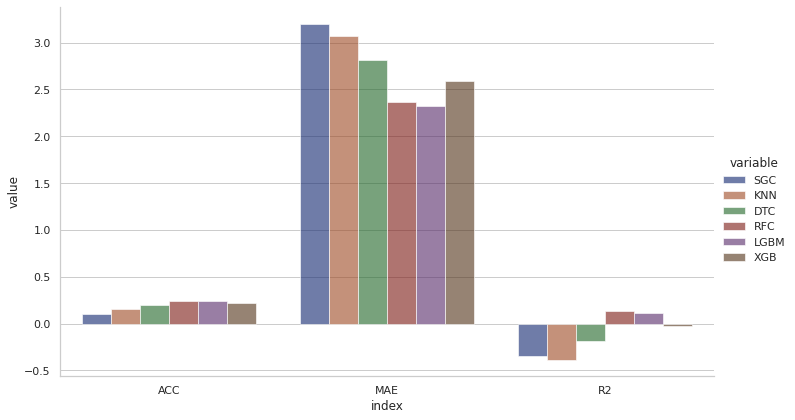

In [10]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=results.melt(ignore_index=False).reset_index(), kind="bar",
    y="value", x="index", hue="variable",
    palette="dark", alpha=.6, height=6,aspect=1.7
)

### *n.b. set graph to share lung scores (binary) based on proxmity (ie share health scores to weather regions)*

In [4]:
GS1d=(df2.pivot_table(values='diag1', index='date', columns='cd9_loc', aggfunc='count').fillna(0).iloc[0].values)
GS1d=(np.repeat(GS1d,2))
# GS1d=GS1d[:-1]
GS1d=(GS1d>0)*1
GS1d

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [6]:
distances = square.apply(get_distance, axis=1).T
D_D=pd.DataFrame((distances<5)*1)
D_D.index=np.arange(0,D_D.shape[1])#data_loc['src']
D_D.columns=np.arange(0,D_D.shape[1])#data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
E_E.reset_index(inplace=True)#
# distance#_mat=E_E[E_E[0]>0]
E_E=E_E[E_E['level_0']!=E_E['level_1']]
s_graph=E_E[E_E[0]>0][['level_0','level_1']].to_numpy()#=distance_mat[['level_0','level_1']].to_numpy()
# n_nodes=36

graph = get_zacharys_karate_club(s_graph)

In [5]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')
  
def get_zacharys_karate_club(s_graph) -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""

  # social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_nodes = np.max(s_graph)+1


  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_nodes]),
      n_edge=jnp.asarray([len(s_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_nodes),
      # No edge features.
      edges=jnp.asarray(s_graph),#None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in s_graph]),
      receivers=jnp.asarray([edge[1] for edge in s_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club(GS1d) -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array(GS1d)

In [7]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders


# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  """Returns a method that applies a Graph Attention Network layer.

  Graph Attention message passing as described in
  https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
  jnp.array, may use edge features for computing attention weights, and
  ignore global features. It does not support nests.
  Args:
    attention_query_fn: function that generates attention queries from sender
      node features.
    attention_logit_fn: function that converts attention queries into logits for
      softmax attention.
    node_update_fn: function that updates the aggregated messages. If None, will
      apply leaky relu and concatenate (if using multi-head attention).

  Returns:
    A function that applies a Graph Attention layer.
  """
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

In [8]:
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)


  return graph


In [12]:
# def optimize_club(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
#   """Solves the karate club problem by optimizing the assignments of students."""
#   zacharys_karate_club = get_zacharys_karate_club(s_graph)
#   labels = get_ground_truth_assignments_for_zacharys_karate_club(GS1d)
#   params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)
#   paramsA=params
@jax.jit
def predict(params: hk.Params) -> jnp.ndarray:
  decoded_graph = network.apply(params, zacharys_karate_club)
  return jnp.argmax(decoded_graph.nodes, axis=1)

@jax.jit
def prediction_loss(params: hk.Params) -> jnp.ndarray:
  decoded_graph = network.apply(params, zacharys_karate_club)
  # We interpret the decoded nodes as a pair of logits for each node.
  log_prob = jax.nn.log_softmax(decoded_graph.nodes)
  # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
  # and John A (Node 33).
  return log_prob #-(log_prob[0, 0] + log_prob[33, 1])

# opt_init, opt_update = optax.adam(1e-2)
# opt_state = opt_init(params)

@jax.jit
def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
  """Returns updated params and state."""
  g = jax.grad(prediction_loss)(params)
  updates, opt_state = opt_update(g, opt_state)
  return optax.apply_updates(params, updates), opt_state

@jax.jit
def accuracy(params: hk.Params) -> jnp.ndarray:
  decoded_graph = network.apply(params, zacharys_karate_club)
  return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

# for step in range(num_steps):
#   print(f"step {step} accuracy {accuracy(params).item():.2f}")
#   params, opt_state = update(params, opt_state)

# def _attention_logit_fn(sender_nodes: jnp.ndarray, receiver_nodes: jnp.ndarray,
#                           edges: jnp.ndarray) -> jnp.ndarray:
#     del edges
#     x = jnp.concatenate((sender_nodes, receiver_nodes), axis=1)
#     return hk.Linear(1)(x)

# return predict(params) #,paramsA,zacharys_karate_club

In [13]:
# StatefulField = collections.namedtuple("StatefulField", ["embedding", "state"])

def network_definition(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
# def LSTM(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
  """`InteractionNetwork` with an LSTM in the edge update."""
  def _attention_logit_fn(sender_nodes: jnp.ndarray, receiver_nodes: jnp.ndarray,
                            edges: jnp.ndarray) -> jnp.ndarray:
      del edges
      x = jnp.concatenate((sender_nodes, receiver_nodes), axis=1)
      return hk.Linear(1)(x)

  # gn = GAT(
  #     attention_query_fn=lambda n: hk.Linear(8)(n),
  #     attention_logit_fn=_attention_logit_fn,
  #     node_update_fn=None,
  #     add_self_edges=True)
  # graph = gn(graph)

  # gn = GAT(
  #     attention_query_fn=lambda n: hk.Linear(8)(n),
  #     attention_logit_fn=_attention_logit_fn,
  #     node_update_fn=hk.Linear(2),
  #     add_self_edges=True)
  # graph = gn(graph)

  # LSTM that will keep a memory of the inputs to the edge model.
  edge_fn_lstm = hk.LSTM(128)

  # MLPs used in the edge and the node model. Note that in this instance
  # the output size matches the input size so the same model can be run
  # iteratively multiple times. In a real model, this would usually be achieved
  # by first using an encoder in the input data into a common `EMBEDDING_SIZE`.
  edge_fn_mlp = hk.nets.MLP([128,32])
  node_fn_mlp = hk.nets.MLP([128,32])

  # Initialize the edge features to contain both the input edge embedding
  # and initial LSTM state. Note for the nodes we only have an embedding since
  # in this example nodes do not use a `node_fn_lstm`, but for analogy, we
  # still put it in a `StatefulField`.
  graph = graph._replace(
      edges=StatefulField(
          embedding=graph.edges,
          state=edge_fn_lstm.initial_state(graph.edges.shape[0])),
      nodes=StatefulField(embedding=graph.nodes, state=None),
  )

  def update_edge_fn(edges, sender_nodes, receiver_nodes):
    # We will run an LSTM memory on the inputs first, and then
    # process the output of the LSTM with an MLP.
    edge_inputs = jnp.concatenate([edges.embedding,
                                   sender_nodes.embedding,
                                   receiver_nodes.embedding], axis=-1)
    lstm_output, updated_state = edge_fn_lstm(edge_inputs, edges.state)
    updated_edges = StatefulField(
        embedding=edge_fn_mlp(lstm_output), state=updated_state,
    )
    return updated_edges

  def update_node_fn(nodes, received_edges):
    # Note `received_edges.state` will also contain the aggregated state for
    # all received edges, which we may choose to use in the node update.
    node_inputs = jnp.concatenate(
        [nodes.embedding, received_edges.embedding], axis=-1)
    updated_nodes = StatefulField(
        embedding=node_fn_mlp(node_inputs),
        state=None)
    return updated_nodes


  recurrent_graph_network = jraph.InteractionNetwork(
      update_edge_fn=update_edge_fn,
      update_node_fn=update_node_fn)

  # Apply the model recurrently for 10 message passing steps.
  # If instead we intended to use the LSTM to process a sequence of features
  # for each node/edge, here we would select the corresponding inputs from the
  # sequence along the sequence axis of the nodes/edges features to build the
  # correct input graph for each step of the iteration.
  num_message_passing_steps = 10
  for _ in range(num_message_passing_steps):
    graph = recurrent_graph_network(graph)

  return graph

In [ ]:
network = hk.without_apply_rng(hk.transform(network_definition))
zacharys_karate_club = get_zacharys_karate_club(s_graph)
labels = get_ground_truth_assignments_for_zacharys_karate_club(GS1d)
params = network.init(jax.random.PRNGKey(42), graph)
paramsA=params

opt_init, opt_update = optax.adam(1e-2)
opt_state = opt_init(params)

for step in range(10):
#     print(f"step {step} accuracy {accuracy(params).item():.2f}")
    params, opt_state = update(params, opt_state)
# predict(params)
jnp.argmax(network.apply(params, zacharys_karate_club).nodes,axis=1)
# output_graph = network.apply(params, input_graph)

# result,params,netA = optimize_club(networkA, num_steps=10)

# network = hk.without_apply_rng(hk.transform(network_definition))
# input_graph = get_random_graph()
# params = network.init(jax.random.PRNGKey(42), input_graph)
# output_graph = network.apply(params, input_graph)
# print(tree.tree_map(lambda x: x.shape, output_graph))


# network = hk.without_apply_rng(hk.transform(network_definition))
# # input_graph = get_random_graph()
# zacharys_karate_club = get_zacharys_karate_club(s_graph)
# params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

# output_graph = network.apply(paramsA, zacharys_karate_club)
# print(tree.tree_map(lambda x: x.shape, output_graph))

# network = hk.without_apply_rng(hk.transform(network_definition))
# output_graph = network.apply(params, netA)

The final node assignment predicted by the trained model:

In [ ]:
zacharys_karate_club = get_zacharys_karate_club(s_graph)
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GAT')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club(GS1d)
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)
plt.show()

lets add in LSTM to model to account for time

[inspired by GRU then LSTM](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/timeseries/ipynb/timeseries_traffic_forecasting.ipynb#scrollTo=hRpthm4r4j6a) | [and from googleBrain code here](https://github.com/deepmind/jraph/blob/master/jraph/examples/lstm.py)